# Trainable MNIST

Raytune has a great collection of [examples](https://github.com/ray-project/ray/tree/master/python/ray/tune/examples) and I have picked a simple one to impement in a notebook. This is godo to play with if you are within a GPU or want to try a *big* parameter search as it's relatively quick and easy to train.


## What is MNIST?

In case you are unfamilar MNIST is a standard handwritten character dataset used widely in Machine Learning examples. The dataset consists of 70,000 28x28 images (60,000 training and 10,000 test)


Here are some examples from the dataset [source: wikipedia](https://en.wikipedia.org/wiki/MNIST_database#/media/File:MnistExamples.png)

![MNIST Examples](MnistExamples.png)



### Load Dependencies

We load the usual deps and also load [PyTorch](https://pytorch.org/docs/stable/index.html) so that we can define a small Neural Network to train as a classifer

In [1]:
%load_ext autoreload
%autoreload 2

from dependencies import *

Loading dependencies we have already seen...
Importing ray...
Done...


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Dataloaders

We'll re-use some standard dataloaders from the ray examples. This function returns 2 pytorch dataloaders, one for train and one for test

In [3]:
from mnist_pytorch import get_data_loaders

## Network

We define a very small ConvNET with a single Conv2D layer and single Linear Layer

Things to Try:
 - Try building up larger networks to see if performance improves
 - Try adding options to the `__init__()` function to vary layer properties or the number of layers and tune these new parameters

In [22]:
class ConvNet(nn.Module):
    def __init__(self, width=3):
        super(ConvNet, self).__init__()       
        self.width=width
        
        self.conv1 = nn.Conv2d(1, width, kernel_size=3)
        self.fc = nn.Linear(width*8*8, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = x.view(-1, self.width*8*8)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

## Train & Test Functions

We define some functions for out training and testing loops

During training, we iterate over examples while calculating losses, backpropagating and optimising the network

In [23]:
EPOCH_SIZE = 512

def train(model, optimizer, train_loader, device=None):
    device = device or torch.device("cpu")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx * len(data) > EPOCH_SIZE:
            return
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

During test time we iterate over the test set and calculate performance metrics

In [24]:
TEST_SIZE=256

def test(model, data_loader, device=None):
    device = device or torch.device("cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            if batch_idx * len(data) > TEST_SIZE:
                break
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

## Check for CUDA

In [25]:
print('CUDA Available :D') if torch.cuda.is_available() else print('CPU Only :O')

CUDA Available :D


## Start Ray

In [26]:
ray.shutdown()
ray.init(num_cpus=2, num_gpus=1, include_webui=True)

2020-06-10 17:10:00,543	INFO resource_spec.py:204 -- Starting Ray with 35.6 GiB memory available for workers and up to 17.8 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-06-10 17:10:00,799	INFO services.py:1168 -- View the Ray dashboard at localhost:8266


{'node_ip_address': '192.168.1.39',
 'raylet_ip_address': '192.168.1.39',
 'redis_address': '192.168.1.39:23315',
 'object_store_address': '/tmp/ray/session_2020-06-10_17-10-00_541713_15557/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-10_17-10-00_541713_15557/sockets/raylet',
 'webui_url': 'localhost:8266',
 'session_dir': '/tmp/ray/session_2020-06-10_17-10-00_541713_15557'}

In [27]:
from os import path

class TrainMNIST(tune.Trainable):
    
    def _setup(self, config):
        # detect if cuda is availalbe as ray will assign GPUs if available and configured
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        #
        # In this case this will also fetch the MNIST data on first run
        #
        self.train_loader, self.test_loader = get_data_loaders()
        
        # create the network
        self.model = ConvNet(
            # pass in parameters here if we want to tune network internals
        ).to(self.device)
        
        #setup the optimiser (try Adam instead and change parameters we are tuning)
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=config.get("lr", 0.01),
            momentum=config.get("momentum", 0.9))
                

    def _train(self):
        
        train(self.model, self.optimizer, self.train_loader, device=self.device)
        
        acc = test(self.model, self.test_loader, self.device)
        
        return {"mean_accuracy": acc}
    
    
    def _save(self, checkpoint_dir):
        checkpoint_path = path.join(checkpoint_dir, "model.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        return checkpoint_path
    
    
    def _restore(self, checkpoint_path):
        self.model.load_state_dict(torch.load(checkpoint_path))

In [28]:
config = {
        "lr": tune.uniform(0.001, 0.1),
        "momentum": tune.uniform(0.1, 0.9),
    }


analysis = tune.run(
    TrainMNIST,
    config=config,
    local_dir="~/ray_results/torch_mnist",
    resources_per_trial={
        "cpu": 2,
        "gpu": 1
    },
    num_samples=3,
    checkpoint_at_end=True,
    checkpoint_freq=10,
#     keep_checkpoints_num=3, # only keep n best checkpoints
    stop={
        "mean_accuracy": 0.99,
        "training_iteration": 100,
    })



Trial name,status,loc,lr,momentum
TrainMNIST_00000,RUNNING,,0.0215441,0.489389
TrainMNIST_00001,PENDING,,0.0743001,0.886683
TrainMNIST_00002,PENDING,,0.00864967,0.189377


(pid=16244) 2020-06-10 17:10:03,559	INFO trainable.py:217 -- Getting current IP.
Result for TrainMNIST_00000:
  date: 2020-06-10_17-10-03
  done: false
  experiment_id: 520f24618fa544a786a301bec67c2588
  experiment_tag: 0_lr=0.021544,momentum=0.48939
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_accuracy: 0.309375
  node_ip: 192.168.1.39
  pid: 16244
  time_since_restore: 0.2740151882171631
  time_this_iter_s: 0.2740151882171631
  time_total_s: 0.2740151882171631
  timestamp: 1591805403
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '00000'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,RUNNING,192.168.1.39:16244,0.0215441,0.489389,0.890625,19,2.90467
TrainMNIST_00001,PENDING,,0.0743001,0.886683,,,
TrainMNIST_00002,PENDING,,0.00864967,0.189377,,,


Result for TrainMNIST_00000:
  date: 2020-06-10_17-10-08
  done: false
  experiment_id: 520f24618fa544a786a301bec67c2588
  experiment_tag: 0_lr=0.021544,momentum=0.48939
  hostname: cosmos-ml
  iterations_since_restore: 35
  mean_accuracy: 0.925
  node_ip: 192.168.1.39
  pid: 16244
  time_since_restore: 5.282199144363403
  time_this_iter_s: 0.15729594230651855
  time_total_s: 5.282199144363403
  timestamp: 1591805408
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: '00000'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,RUNNING,192.168.1.39:16244,0.0215441,0.489389,0.909375,53,7.94496
TrainMNIST_00001,PENDING,,0.0743001,0.886683,,,
TrainMNIST_00002,PENDING,,0.00864967,0.189377,,,


Result for TrainMNIST_00000:
  date: 2020-06-10_17-10-14
  done: false
  experiment_id: 520f24618fa544a786a301bec67c2588
  experiment_tag: 0_lr=0.021544,momentum=0.48939
  hostname: cosmos-ml
  iterations_since_restore: 69
  mean_accuracy: 0.921875
  node_ip: 192.168.1.39
  pid: 16244
  time_since_restore: 10.310583353042603
  time_this_iter_s: 0.15134024620056152
  time_total_s: 10.310583353042603
  timestamp: 1591805414
  timesteps_since_restore: 0
  training_iteration: 69
  trial_id: '00000'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,RUNNING,192.168.1.39:16244,0.0215441,0.489389,0.9375,85,12.8417
TrainMNIST_00001,PENDING,,0.0743001,0.886683,,,
TrainMNIST_00002,PENDING,,0.00864967,0.189377,,,


Result for TrainMNIST_00000:
  date: 2020-06-10_17-10-19
  done: true
  experiment_id: 520f24618fa544a786a301bec67c2588
  experiment_tag: 0_lr=0.021544,momentum=0.48939
  hostname: cosmos-ml
  iterations_since_restore: 100
  mean_accuracy: 0.93125
  node_ip: 192.168.1.39
  pid: 16244
  time_since_restore: 15.250997304916382
  time_this_iter_s: 0.15807795524597168
  time_total_s: 15.250997304916382
  timestamp: 1591805419
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: '00000'
  
(pid=16243) 2020-06-10 17:10:21,282	INFO trainable.py:217 -- Getting current IP.
Result for TrainMNIST_00001:
  date: 2020-06-10_17-10-21
  done: false
  experiment_id: f7d3a0acb6c74fbeb19209fe267caf4f
  experiment_tag: 1_lr=0.0743,momentum=0.88668
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_accuracy: 0.48125
  node_ip: 192.168.1.39
  pid: 16243
  time_since_restore: 0.27214694023132324
  time_this_iter_s: 0.27214694023132324
  time_total_s: 0.27214694023132324
  timestamp: 159

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,TERMINATED,,0.0215441,0.489389,0.93125,100,15.251
TrainMNIST_00001,RUNNING,192.168.1.39:16243,0.0743001,0.886683,0.840625,2,0.418721
TrainMNIST_00002,PENDING,,0.00864967,0.189377,,,


Result for TrainMNIST_00001:
  date: 2020-06-10_17-10-26
  done: false
  experiment_id: f7d3a0acb6c74fbeb19209fe267caf4f
  experiment_tag: 1_lr=0.0743,momentum=0.88668
  hostname: cosmos-ml
  iterations_since_restore: 35
  mean_accuracy: 0.96875
  node_ip: 192.168.1.39
  pid: 16243
  time_since_restore: 5.222405910491943
  time_this_iter_s: 0.1487886905670166
  time_total_s: 5.222405910491943
  timestamp: 1591805426
  timesteps_since_restore: 0
  training_iteration: 35
  trial_id: '00001'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,TERMINATED,,0.0215441,0.489389,0.93125,100,15.251
TrainMNIST_00001,RUNNING,192.168.1.39:16243,0.0743001,0.886683,0.94375,36,5.36914
TrainMNIST_00002,PENDING,,0.00864967,0.189377,,,


Result for TrainMNIST_00001:
  date: 2020-06-10_17-10-31
  done: false
  experiment_id: f7d3a0acb6c74fbeb19209fe267caf4f
  experiment_tag: 1_lr=0.0743,momentum=0.88668
  hostname: cosmos-ml
  iterations_since_restore: 68
  mean_accuracy: 0.940625
  node_ip: 192.168.1.39
  pid: 16243
  time_since_restore: 10.160768747329712
  time_this_iter_s: 0.14750361442565918
  time_total_s: 10.160768747329712
  timestamp: 1591805431
  timesteps_since_restore: 0
  training_iteration: 68
  trial_id: '00001'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,TERMINATED,,0.0215441,0.489389,0.93125,100,15.251
TrainMNIST_00001,RUNNING,192.168.1.39:16243,0.0743001,0.886683,0.93125,69,10.3089
TrainMNIST_00002,PENDING,,0.00864967,0.189377,,,


Result for TrainMNIST_00001:
  date: 2020-06-10_17-10-36
  done: false
  experiment_id: f7d3a0acb6c74fbeb19209fe267caf4f
  experiment_tag: 1_lr=0.0743,momentum=0.88668
  hostname: cosmos-ml
  iterations_since_restore: 98
  mean_accuracy: 0.96875
  node_ip: 192.168.1.39
  pid: 16243
  time_since_restore: 15.115023851394653
  time_this_iter_s: 0.17007684707641602
  time_total_s: 15.115023851394653
  timestamp: 1591805436
  timesteps_since_restore: 0
  training_iteration: 98
  trial_id: '00001'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,TERMINATED,,0.0215441,0.489389,0.93125,100,15.251
TrainMNIST_00001,RUNNING,192.168.1.39:16243,0.0743001,0.886683,0.965625,99,15.2804
TrainMNIST_00002,PENDING,,0.00864967,0.189377,,,


Result for TrainMNIST_00001:
  date: 2020-06-10_17-10-37
  done: true
  experiment_id: f7d3a0acb6c74fbeb19209fe267caf4f
  experiment_tag: 1_lr=0.0743,momentum=0.88668
  hostname: cosmos-ml
  iterations_since_restore: 100
  mean_accuracy: 0.953125
  node_ip: 192.168.1.39
  pid: 16243
  time_since_restore: 15.450169324874878
  time_this_iter_s: 0.16977930068969727
  time_total_s: 15.450169324874878
  timestamp: 1591805437
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: '00001'
  
(pid=16368) 2020-06-10 17:10:39,520	INFO trainable.py:217 -- Getting current IP.
Result for TrainMNIST_00002:
  date: 2020-06-10_17-10-39
  done: false
  experiment_id: 91fa21b6e236449a9c99d4632c4175c3
  experiment_tag: 2_lr=0.0086497,momentum=0.18938
  hostname: cosmos-ml
  iterations_since_restore: 1
  mean_accuracy: 0.1875
  node_ip: 192.168.1.39
  pid: 16368
  time_since_restore: 0.28435850143432617
  time_this_iter_s: 0.28435850143432617
  time_total_s: 0.28435850143432617
  timestamp: 15

Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,TERMINATED,,0.0215441,0.489389,0.93125,100,15.251
TrainMNIST_00001,TERMINATED,,0.0743001,0.886683,0.953125,100,15.4502
TrainMNIST_00002,RUNNING,192.168.1.39:16368,0.00864967,0.189377,0.85,15,2.39136


Result for TrainMNIST_00002:
  date: 2020-06-10_17-10-44
  done: false
  experiment_id: 91fa21b6e236449a9c99d4632c4175c3
  experiment_tag: 2_lr=0.0086497,momentum=0.18938
  hostname: cosmos-ml
  iterations_since_restore: 34
  mean_accuracy: 0.8625
  node_ip: 192.168.1.39
  pid: 16368
  time_since_restore: 5.224001169204712
  time_this_iter_s: 0.1489722728729248
  time_total_s: 5.224001169204712
  timestamp: 1591805444
  timesteps_since_restore: 0
  training_iteration: 34
  trial_id: '00002'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,TERMINATED,,0.0215441,0.489389,0.93125,100,15.251
TrainMNIST_00001,TERMINATED,,0.0743001,0.886683,0.953125,100,15.4502
TrainMNIST_00002,RUNNING,192.168.1.39:16368,0.00864967,0.189377,0.878125,49,7.42556


Result for TrainMNIST_00002:
  date: 2020-06-10_17-10-49
  done: false
  experiment_id: 91fa21b6e236449a9c99d4632c4175c3
  experiment_tag: 2_lr=0.0086497,momentum=0.18938
  hostname: cosmos-ml
  iterations_since_restore: 68
  mean_accuracy: 0.871875
  node_ip: 192.168.1.39
  pid: 16368
  time_since_restore: 10.246721267700195
  time_this_iter_s: 0.1440119743347168
  time_total_s: 10.246721267700195
  timestamp: 1591805449
  timesteps_since_restore: 0
  training_iteration: 68
  trial_id: '00002'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,TERMINATED,,0.0215441,0.489389,0.93125,100,15.251
TrainMNIST_00001,TERMINATED,,0.0743001,0.886683,0.953125,100,15.4502
TrainMNIST_00002,RUNNING,192.168.1.39:16368,0.00864967,0.189377,0.90625,82,12.3465


Result for TrainMNIST_00002:
  date: 2020-06-10_17-10-54
  done: true
  experiment_id: 91fa21b6e236449a9c99d4632c4175c3
  experiment_tag: 2_lr=0.0086497,momentum=0.18938
  hostname: cosmos-ml
  iterations_since_restore: 100
  mean_accuracy: 0.93125
  node_ip: 192.168.1.39
  pid: 16368
  time_since_restore: 15.166840553283691
  time_this_iter_s: 0.1597919464111328
  time_total_s: 15.166840553283691
  timestamp: 1591805454
  timesteps_since_restore: 0
  training_iteration: 100
  trial_id: '00002'
  


Trial name,status,loc,lr,momentum,acc,iter,total time (s)
TrainMNIST_00000,TERMINATED,,0.0215441,0.489389,0.93125,100,15.251
TrainMNIST_00001,TERMINATED,,0.0743001,0.886683,0.953125,100,15.4502
TrainMNIST_00002,TERMINATED,,0.00864967,0.189377,0.93125,100,15.1668


In [33]:
from pprint import pprint
print("Best config is:")
pprint(analysis.get_best_trial(metric="mean_accuracy"))
pprint(analysis.get_best_config(metric="mean_accuracy"))

Best config is:
TrainMNIST_00001
{'lr': 0.07430007313597342, 'momentum': 0.8866826908317605}


## Load a model and check results

In [30]:
train_loader, test_loader = get_data_loaders()

In [31]:
X, y = list(test_loader)[np.random.randint(0, len(test_loader))]

#### Find the model checkpoint you want to load

In [34]:
checkpoint_path = path.join(path.expanduser('~'),'ray_results','torch_mnist','TrainMNIST',
                          'TrainMNIST_1_lr=0.0743,momentum=0.88668_2020-06-10_17-10-19o_jnd3ec',
                         'checkpoint_100', 'model.pth')

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.set_grad_enabled(False):
    model = ConvNet()
    model.load_state_dict(torch.load(checkpoint_path))
    
    model.to(device)
    
    y_ = model(X.to(device)).cpu()
    
    _, predicted = torch.max(y_, 1)

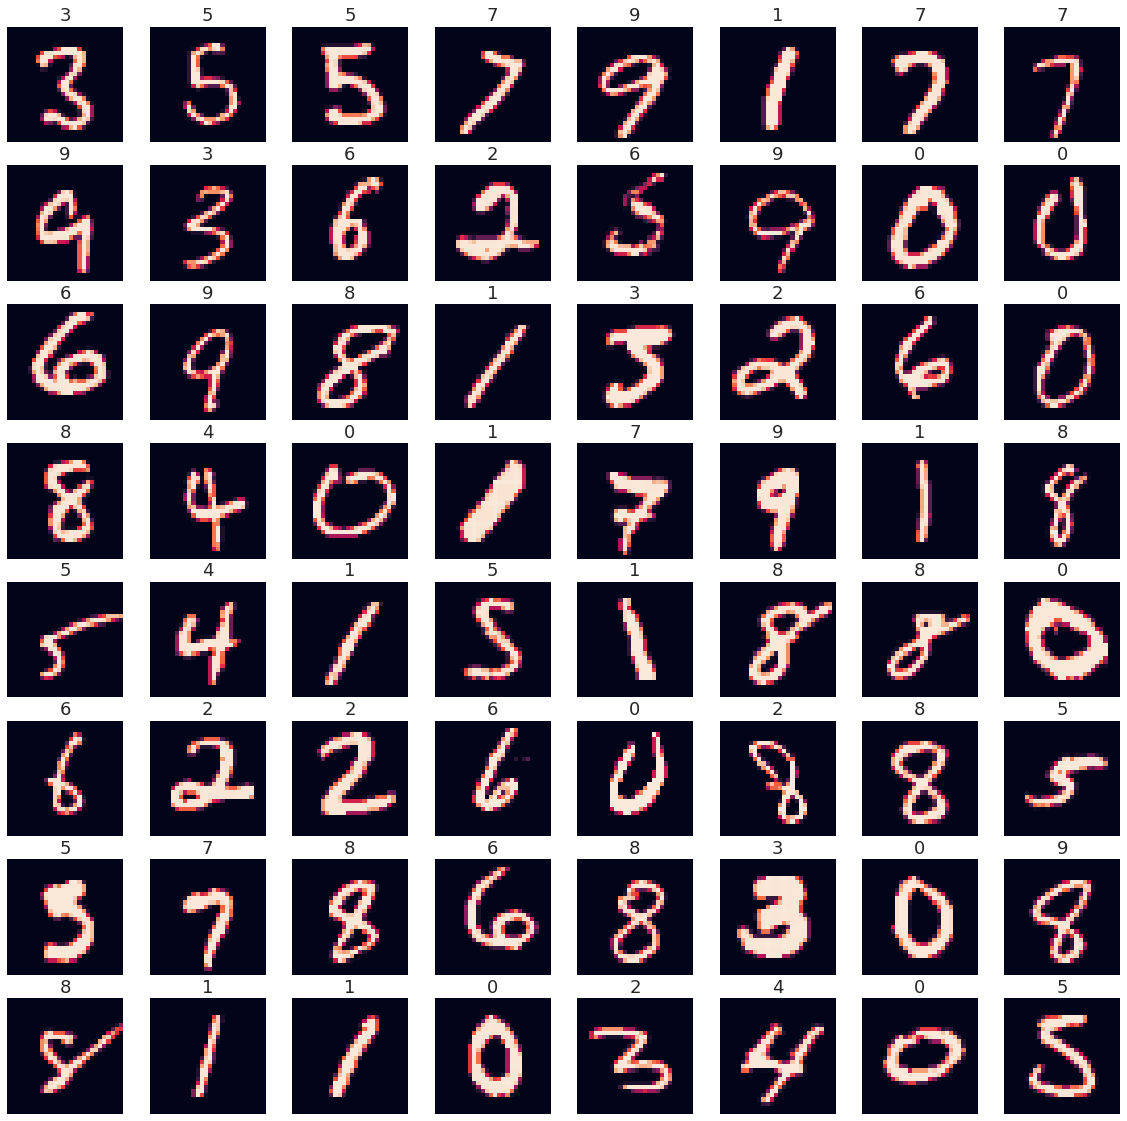

In [36]:
fig, axs = plt.subplots(8,8, figsize=(20,20))
axsf = [item for s in axs for item in s]

for n,ax in enumerate(axsf):
    ax.imshow(X[n].squeeze().numpy())
    ax.axis('off')
    ax.set_title(predicted[n].item())
    
plt.show()

In [ ]:
# https://github.com/ray-project/ray/issues/4569

In [ ]:
# Exercises
# - change out the optimiser for adam
# - add network hyperparameters